In [8]:
"""
This program produces the mismatch contour over 2D parameters.
Soumen Roy (2021)
"""
from __future__ import division
import numpy as np
import lal
import lalsimulation as lalsim

import lalsimulation as lalsim
import h5py

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}',r'\mathchardef\mhyphen="2D']
plt.style.use('MATPLOTLIB_RCPARAMS.sty')

import utils


def generate_waveform(m1, m2, S1, S2, iota, psi, ra, dec, time, phase, \
            deltaT=1.0/4096.0, flow=20.0, fref=20.0, detList=['L1'], nonGRparams=None, \
            distance = 100,  approx='SEOBNRv4_opt', equal_size_strain=None):
    
    uts =  utils.MiscellaneousUtils()
    uts.approx = approx
    
    uts.deltaT = deltaT
    uts.fmin = flow
    uts.fref = fref
    
    uts.mass1 = m1
    uts.mass2 = m2
    uts.spin1x, uts.spin1y, uts.spin1z = S1 
    uts.spin2x, uts.spin2y, uts.spin2z = S2
    
    uts.iota = iota
    uts.phiref = phase
    uts.dist = distance*lal.PC_SI*1e6
    
    uts.nonGRparams = nonGRparams
    
    hp, hc = uts._gen_waveform( polarizations=True)
    
    # XLALSimInspiralChooseTDWaveform always ends the waveform at t=0 
    # So we can adjust the epoch so that the end time is as desired 
    # An ddditional time shift is performed assuming that the absoulte
    # square of the gravitational wave signal in radiation frame at geocenter
    # has the maximum at time t_c, where t_c = 'time'.
    sqrAmp =  np.abs(hp.data.data[:])**2 + np.abs(hc.data.data[:])**2 
    time_shift = (hp.data.length - np.where( sqrAmp == np.max(sqrAmp) )[0][0] )*hp.deltaT
    time += time_shift 
    hp.epoch = time 
    hc.epoch = time
    
    strain_dic = {}
    
    for det in detList:
        strain = lalsim.SimDetectorStrainREAL8TimeSeries( \
                        hp, hc, ra, dec, psi, lalsim.DetectorPrefixToLALDetector(det))
        
        if equal_size_strain:
            strain_dic[det] =  strain
        else:
            times = np.arange( strain.data.length )*uts.deltaT - (strain.data.length-1)*uts.deltaT + float(strain.epoch)
            strain_dic[det] = {'strain': strain.data.data, 'times': times}
            
    if equal_size_strain:
        max_end_time = max([ float(strain_dic[det].epoch) for det in detList]) + 100*uts.deltaT
        min_start_time = min([ float(strain_dic[det].epoch) - strain_dic[det].data.length*uts.deltaT \
                              for det in detList]) - 100*uts.deltaT
        times = np.arange( min_start_time, max_end_time+uts.deltaT, uts.deltaT  )
        
        for det in detList:
            strain = np.zeros(len(times))
            
            if strain_dic[det].epoch == max_end_time:
                strain[ - strain_dic[det].data.length : ] = strain_dic[det].data.data
            else:
                end_idx = int( (max_end_time - float(strain_dic[det].epoch))/uts.deltaT )
                strain[ -(end_idx + strain_dic[det].data.length) :-end_idx ] = strain_dic[det].data.data
            
            strain_dic[det] = {'times': times, 'strain': strain}
                
    
    return strain_dic


def _gen_Kvector( time, ra, dec, psi, det_list=['H1', 'L1', 'V1'] ):
    """
    Construct the coefficients of the detector patterns and computes the
    time delay of the detector from the earth center. 
    
    Example for the three detector case
    K1(ra, dec) = F2_+ F3_x − F2_x F3_+
    K2(ra, dec) = F3_+ F1_x − F3_x F1_+
    K3(ra, dec) = F1_+ F2_x − F1_x F2_+
    
    """
    fp_fc_dic = {}
    for det in det_list:
        detector = lal.cached_detector_by_prefix[det]
        Fp, Fc = lal.ComputeDetAMResponse(detector.response, ra, \
                                    dec, psi, lal.GreenwichMeanSiderealTime(time))
        fp_fc_dic[det] = {'F+': Fp, 'Fx': Fc}
    
    kvector_dic = {}
    time_delay_dic = {}
    n_det = len(det_list)
    for ii in range( n_det ):
        det = det_list[ ii ]
        kvector_dic[det] = fp_fc_dic[ det_list[(ii+1)%n_det] ]['F+'] * fp_fc_dic[ det_list[(ii+2)%n_det] ]['Fx'] - \
                        fp_fc_dic[ det_list[(ii+1)%n_det] ]['Fx'] * fp_fc_dic[ det_list[(ii+2)%n_det] ]['F+']
        
        time_delay_dic[det] = lal.TimeDelayFromEarthCenter( \
                        lalsim.DetectorPrefixToLALDetector(det ).location, ra, dec, time)
        
    return kvector_dic, time_delay_dic
    

def null_statistic(time, ra, dec, psi, wf_dic):
    """
    Calculate the statistic for zero noise case
    
    parameters: \lambda = {ra, dec, psi}
    Detector patter function: Ki = Ki( \lambda )
    
    Statistic: I(t, \lambda) = ( K1 R1(t) + K2 R2(t) + K3 R3(t) )/(K1^2 + K2^2 + K3^2)^{1/2}
    """
    
    det_list = list(wf_dic.keys())
    kvector_dic, time_delay_dic = _gen_Kvector( time, ra, dec, psi, det_list=det_list )
    I = np.sum([ np.roll( wf_dic[det]['strain'], int( -time_delay_dic[det]/delta_t ) ) *kvector_dic[det] \
                for det in det_list ], axis=0)
    statistic = np.sum(np.abs(I)**2) * delta_t / np.sum( np.square( [kvector_dic[det] for det in det_list] ) )
    return statistic


### Generate the waveform in detector frame

* $R_1(t, \Delta t^{\rm{GC}}_{1}) = F_{1+}(\alpha, \delta)h_+(t, \Delta t^{\rm{GC}}_{1}) + F_{1\times}(\alpha, \delta)h_\times(t, \Delta t^{\rm{GC}}_{1})$
* $R_2(t, \Delta t^{\rm{GC}}_{2}) = F_{2+}(\alpha, \delta)h_+(t, \Delta t^{\rm{GC}}_{2}) + F_{2\times}(\alpha, \delta)h_\times(t, \Delta t^{\rm{GC}}_{2})$
* $R_3(t, \Delta t^{\rm{GC}}_{3}) = F_{3+}(\alpha, \delta)h_+(t, \Delta t^{\rm{GC}}_{3}) + F_{3\times}(\alpha, \delta)h_\times(t, \Delta t^{\rm{GC}}_{3})$

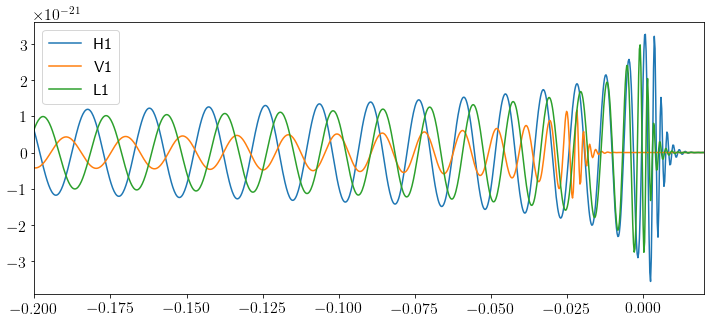

In [65]:
m1Inj = 20.0
m2Inj = 15.0
S1Inj = [0.0, 0.0, 0.0]
S2Inj = [0.0, 0.0, 0.0]
iotaInj = 0.0
psiInj = 0.0
raInj = 3.44
decInj = -0.4
timeInj = 1187008882
phaseInj = 0.3

wf_dic = generate_waveform(m1Inj, m2Inj, S1Inj, S2Inj, iotaInj, psiInj, raInj, decInj, timeInj, phaseInj, \
        deltaT=1.0/4096.0, flow=30.0, fref=0.0, detList=['H1', 'L1', 'V1'], equal_size_strain=None)

# plot the waveform
fig, ax = plt.subplots( figsize=(12, 5) )
for det in wf_dic.keys():
    plt.plot(wf_dic[det]['times']-timeInj, wf_dic[det]['strain'], label=det )
plt.xlim(-0.2, 0.02)
plt.legend()

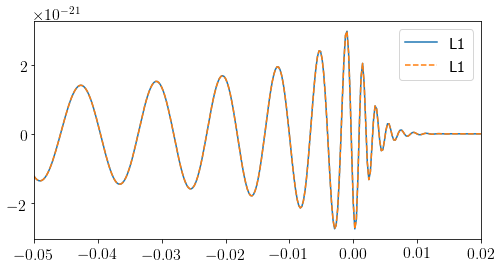

In [60]:
wf_dic0 = generate_waveform(m1Inj, m2Inj, S1Inj, S2Inj, iotaInj, psiInj, raInj, decInj, timeInj, phaseInj, \
        deltaT=1.0/4096.0, flow=30.0, fref=20.0, detList=['H1', 'L1', 'V1'], equal_size_strain=None)

wf_dic1 = generate_waveform(m1Inj, m2Inj, S1Inj, S2Inj, iotaInj, psiInj, raInj, decInj, timeInj, phaseInj, \
        deltaT=1.0/4096.0, flow=30.0, fref=20.0, detList=['H1', 'L1', 'V1'], equal_size_strain=True)

det = 'L1'
plt.plot(wf_dic1[det]['times']-timeInj, wf_dic1[det]['strain'], label=det )

plt.plot(wf_dic0[det]['times']-timeInj, wf_dic0[det]['strain'], label=det, ls='--' )
plt.xlim(-0.05, 0.02)
plt.legend()

In [12]:
det_list = ['H1', 'L1', 'V1']
wf_dic = generate_waveform(m1Inj, m2Inj, S1Inj, S2Inj, iotaInj, psiInj, raInj, decInj, timeInj, phaseInj, \
        deltaT=1.0/4096.0, flow=30.0, fref=20.0, detList=det_list, equal_size_strain=True)
kvector_dic, time_delay_dic = _gen_Kvector( timeInj, raInj, decInj, psiInj, det_list=det_list )
#time_delay_dic = {}
#for det in det_list:
#    idx = np.where( np.abs(wf_dic[det]['strain']) == np.max( np.abs(wf_dic[det]['strain']) )  )[0][0]
#    time_delay_dic[det] = wf_dic[det]['times'][idx] -timeInj

In [13]:

I = np.sum([ np.roll( wf_dic[det]['strain'], int( -time_delay_dic[det]*4096 ) ) *kvector_dic[det] for det in det_list ], axis=0)

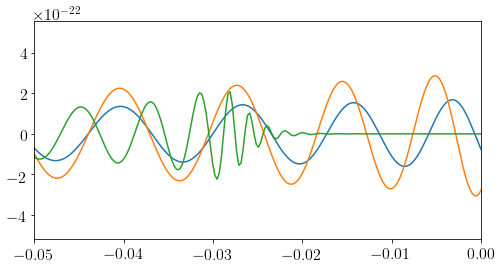

In [14]:
for det in det_list:
    plt.plot(wf_dic[det]['times']-timeInj,  np.roll( wf_dic[det]['strain'], int( time_delay_dic[det]*4096 ) )*kvector_dic[det] )
    plt.xlim(-0.05, 0.0)


In [15]:
plt.plot(wf_dic[det]['times']-timeInj, I)
#plt.xlim(-0.05, 0.0)

## * Grid over sky location

### Null stream statistic:  $\mathcal{L}(\alpha, \delta) = \int I^2(t, \alpha, \delta) dt$
### $I(t, \alpha, \delta) \equiv \frac{ K_1(\alpha, \delta) R_1(t) + K_2(\alpha, \delta) R_2(t) +  K_3(\alpha, \delta) R_3(t) } {\sqrt{K_1^2 + K_2^2 + K_3^2}}$

* $K_1(\alpha, \delta) = F_{2+}F_{3\times} - F_{2\times}F_{3+}$
* $K_2(\alpha, \delta) = F_{3+}F_{1\times} - F_{3\times}F_{1+}$
* $K_3(\alpha, \delta) = F_{1+}F_{2\times} - F_{1\times}F_{2+}$


In [66]:
det_list = ['H1', 'L1', 'V1']
delta_t = 1.0/4096
m1Inj = 30.0
m2Inj = 10.0
S1Inj = [0.0, 0.0, 0.0]
S2Inj = [0.0, 0.0, 0.0]
iotaInj = 0.0
psiInj = 0.0
phaseInj = 0.3
raInj = 3.44
decInj = -0.4
timeInj = 1187008882


wf_dic = generate_waveform(m1Inj, m2Inj, S1Inj, S2Inj, iotaInj, psiInj, raInj, decInj, timeInj, phaseInj, \
        deltaT=1.0/4096.0, flow=20.0, fref=20.0, detList=det_list, equal_size_strain=True)

npts = 200
raArr = np.linspace( 0.0, 2.0*lal.PI, npts )
decArr = np.linspace( -lal.PI/2, lal.PI/2, npts )
raGrid, decGrid = np.meshgrid( raArr, decArr )
sts_grid = np.zeros(raGrid.shape)
for ii in range( npts ):
    for jj in range(npts):
        sts_grid[ii, jj] = null_statistic(timeInj, raGrid[ii, jj], decGrid[ii, jj], psiInj, wf_dic)

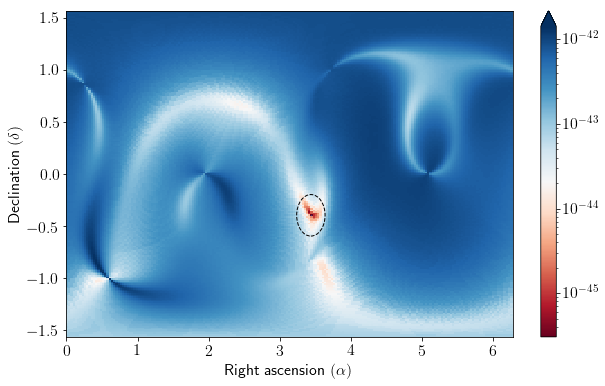

In [70]:
import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(10, 6))
pcm = ax.pcolor(raGrid, decGrid, sts_grid,
                   norm=colors.LogNorm(vmin=sts_grid.min(), vmax=sts_grid.max()),
                   cmap='RdBu')

circle = plt.Circle((raInj, decInj), 0.2, color='k', ls='--', fill=False)
ax.add_patch(circle)
ax.plot( [raInj], [decInj], 'o', markersize=0.2 )
ax.set_xlabel(r'Right ascension $(\alpha)$')
ax.set_ylabel(r'Declination $(\delta)$')
fig.colorbar(pcm, ax=ax, extend='max')
#fig.tight_layout()
#plt.savefig('null_stream.png', dpi=200)

In [71]:
raGrid[ np.where(sts_grid == sts_grid.min()) ][0]

3.441543710967713

In [72]:
det_list = ['H1', 'L1', 'V1']
wf_dic = generate_waveform(m1Inj, m2Inj, S1Inj, S2Inj, iotaInj, psiInj, raInj, decInj, timeInj, phaseInj, \
        deltaT=1.0/4096.0, flow=30.0, fref=20.0, detList=det_list, equal_size_strain=True)



kvector_dic, time_delay_dic = _gen_Kvector( timeInj, raInj, decInj, psiInj, det_list=det_list )
I1 = np.sum([ np.roll( wf_dic[det]['strain'], int( -time_delay_dic[det]*4096 ) ) *kvector_dic[det] for det in det_list ], axis=0)


kvector_dic, time_delay_dic = _gen_Kvector( timeInj, raGrid[ np.where(sts_grid == sts_grid.min()) ][0], \
                                decGrid[ np.where(sts_grid == sts_grid.min()) ][0], psiInj, det_list=det_list )
I2 = np.sum([ np.roll( wf_dic[det]['strain'], int( -time_delay_dic[det]*4096 ) ) *kvector_dic[det] for det in det_list ], axis=0)


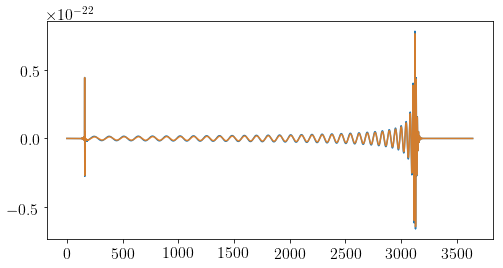

In [75]:
plt.plot(I1)
plt.plot(I2, alpha=0.8)

In [76]:
time_delay_dic = {}
for det in det_list:
    idx = np.where( np.abs(wf_dic[det]['strain']) == np.max( np.abs(wf_dic[det]['strain']) )  )[0][0]
    time_delay_dic[det] = -wf_dic[det]['times'][idx] +timeInj
print( time_delay_dic )
kvector_dic, time_delay_dic2 = _gen_Kvector( timeInj, raInj, decInj, psiInj, det_list=det_list )
print( time_delay_dic2 )

{'H1': -0.002197265625, 'V1': 0.0234375, 'L1': 0.001220703125}
{'H1': 0.01869633711460283, 'V1': -0.006585356506335848, 'L1': 0.015382561938881746}


In [87]:
fig, ax = plt.subplots( figsize=(12, 5) )

colors = {'H1': 'b', 'L1': 'r', 'V1': 'y'}
#_, time_delay_dic = _gen_Kvector( timeInj, raInj, decInj, psiInj, det_list=det_list )
for det in wf_dic.keys():
    plt.plot(wf_dic[det]['times']-timeInj, np.abs(wf_dic[det]['strain']), label=det, c=colors[det] )
    plt.axvline( -time_delay_dic[det], ls='--', color=colors[det])
    plt.axvline( time_delay_dic2[det]+0.014161858813881746, ls='--', color=colors[det], alpha=0.5)
    
plt.xlim(-0.05, 0.02)

(-0.05, 0.02)

In [85]:
-time_delay_dic[det]+ time_delay_dic2[det]

0.014161858813881746

In [44]:
uts =  utils.MiscellaneousUtils()
uts.approx = 'SEOBNRv4_opt'
    
uts.deltaT = 1.0/4096.0
uts.fmin = 30.0
uts.fref = 0.0
    
uts.mass1 = 30.0
uts.mass2 = 10.0
uts.spin1x, uts.spin1y, uts.spin1z = S1Inj
uts.spin2x, uts.spin2y, uts.spin2z = S2Inj
    
uts.iota = iotaInj
uts.phiref = phaseInj
uts.dist = 100*lal.PC_SI*1e6
    
    
uts.psi = psiInj
uts.theta = raInj
uts.phi = decInj 
uts.event_time = timeInj 
uts.phase = phaseInj

detList = ['L1', 'H1', 'V1']
mywf_dic = {}
for det in detList:
    uts.detector = det
    mywf_dic[det] = uts._gen_waveform()

kvector, _ = _gen_Kvector( timeInj, raInj, decInj, psiInj, det_list=detList )

In [45]:
wf = np.sum([ kvector[det]* mywf_dic[det].data.data for det in detList], axis=0)

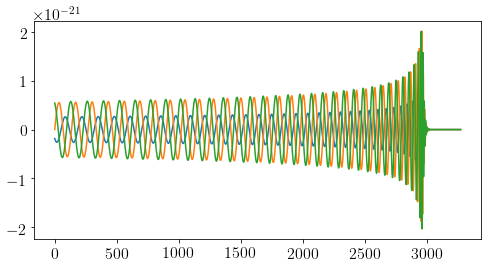

In [46]:
for det in detList:
    plt.plot(mywf_dic[det].data.data)

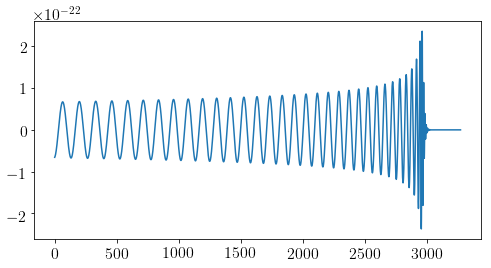

In [47]:
plt.plot(wf)

In [49]:
hp, hc = uts._gen_waveform(polarizations=True)

In [50]:
hp.epoch

LIGOTimeGPS(0, -723690031)

In [51]:
hc.epoch

LIGOTimeGPS(0, -723690031)